<a href="https://colab.research.google.com/github/n-leonovets/DS_course/blob/main/Neural_networks/NLP/Text_classification/JobsMessageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libs

In [1]:
!pip install nltk
!pip install emoji --upgrade
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.7 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import re
import emoji
import string

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from pymystem3 import Mystem

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Freeze seeds

In [4]:
np.random.seed(42)

## Get the dataset

In [86]:
text_data = pd.read_csv('msg_type_4_160.csv')

## Tokenization

In [87]:
tokenizer = TweetTokenizer()

## Stemming

In [88]:
stemmer = SnowballStemmer("russian")

## Lemmaization

In [89]:
mystem = Mystem()

## Vectorize using TFIDF

In [90]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('russian'))

## Split dataset to parameters and encode target labels

In [91]:
df = text_data.copy()

###  Label encode categories

In [92]:
label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(df['category'])

### Split into params and target values

In [93]:
X = df['text']
y = encoded_target

## Perform transformation on df

In [94]:
def remove_emoji(text: str) -> str:
    return emoji.replace_emoji(text, " ")


def remove_links(text: str) -> str:
    return re.sub(r"http\S+", " ", text, flags=re.MULTILINE)


def remove_usernames_and_emails(text: str) -> str:
    """Удалеяет юзернеймы и email"""
    return re.sub(r"\S*@\S*", " ", text, flags=re.MULTILINE)


def remove_punctuation(text: str) -> str:
    """Удаляем символы пунктуации"""
    return "".join([ch if ch not in string.punctuation else " " for ch in text])


def remove_numbers(text: str) -> str:
    """Удаляем числа"""
    return "".join([i if not i.isdigit() else " " for i in text])


def remove_multiple_spaces(text: str) -> str:
    """Удаляем двойные (и более) пробелы"""
    return re.sub(r"\s+", " ", text, flags=re.I)

In [73]:
def get_prep_text(text: str) -> str:
  return remove_multiple_spaces(
      remove_numbers(
          remove_punctuation(
              remove_usernames_and_emails(
                  remove_links(
                      remove_emoji(text)
                      )
                  )
              )
          )
      )

In [95]:
#our new dataset with stemmed lemmatized and later vectorized texts
stemmed_lemma_txts = []

for text in X:
  tok = tokenizer.tokenize(get_prep_text(text).lower())
  stem_tok = [stemmer.stem(token) for token in tok]
  # lem_tok = [lem for lem in mystem.lemmatize(" ".join(stem_tok)) if not lem.isspace()]
  # stemmed_lemma_txts.append(' '.join(lem_tok))
  stemmed_lemma_txts.append(' '.join(stem_tok))

df['text_lemm'] = stemmed_lemma_txts

### TFIDF Vectorize

In [96]:
tfidfd = tfidf_vectorizer.fit_transform(stemmed_lemma_txts)

## Split dataset

pass tfidf'd and transfromed data instead of texts as X

In [97]:
X_train, X_test, y_train, y_test = train_test_split(tfidfd, y, stratify=y, test_size=0.25, random_state=42)

# Model

## Create and train baseline model

In [98]:
model = LogisticRegression(C=0.004)
model.fit(X_train, y_train)

LogisticRegression(C=0.004)

## Predict

In [99]:
y_pred = model.predict(X_test)

## Evaluate

### Accuracy

In [100]:
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

Accuracy: 0.8375


### Report

In [101]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.86        40
           1       0.74      0.97      0.84        40
           2       0.85      0.72      0.78        40
           3       0.85      0.88      0.86        40

    accuracy                           0.84       160
   macro avg       0.85      0.84      0.84       160
weighted avg       0.85      0.84      0.84       160



## Confusion matrix

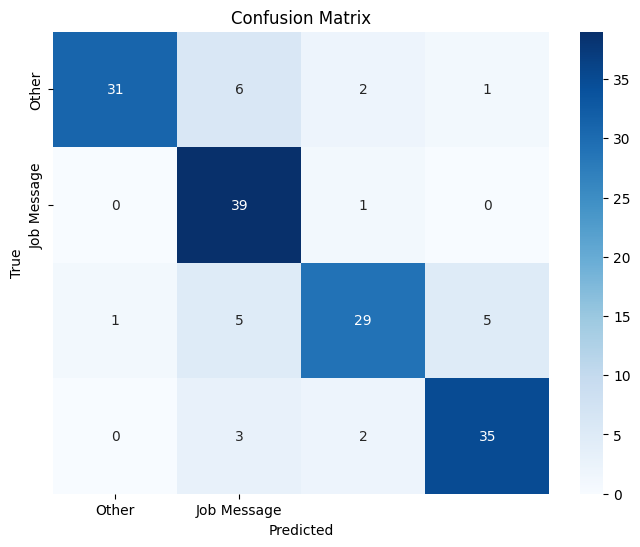

In [102]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Other", "Job Message"], yticklabels=["Other", "Job Message"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Sum it up

In [103]:
# X_train, X_test, y_train, y_test
print(X_train[0])
print("\n")
print(X_test[0])
print("\n")
print(y_train[0])
print("\n")
print(y_test[0])

  (0, 3151)	0.21678446733672
  (0, 3719)	0.2446958797050857
  (0, 3989)	0.2562801624957928
  (0, 3651)	0.27260729207345136
  (0, 1874)	0.27260729207345136
  (0, 2583)	0.1414113807877708
  (0, 1450)	0.2562801624957928
  (0, 1909)	0.23571041189572217
  (0, 2345)	0.23571041189572217
  (0, 4419)	0.40091467551812277
  (0, 2243)	0.18195304790316688
  (0, 3810)	0.17988758715899078
  (0, 1075)	0.15852043117094153
  (0, 3335)	0.0783438080628773
  (0, 4507)	0.11757087209755003
  (0, 1521)	0.12022684486877167
  (0, 645)	0.13498344896463618
  (0, 1108)	0.1245712804996812
  (0, 3061)	0.15852043117094153
  (0, 2390)	0.3706936099731598


  (0, 603)	0.16254635211236865
  (0, 2398)	0.1551989909622506
  (0, 4183)	0.16254635211236865
  (0, 1152)	0.14949993489715568
  (0, 3971)	0.3103979819245012
  (0, 2267)	0.14090647956511237
  (0, 3681)	0.16254635211236865
  (0, 1590)	0.14949993489715568
  (0, 1346)	0.14090647956511237
  (0, 2275)	0.14090647956511237
  (0, 983)	0.13749610589069783
  (0, 1670)	0.1344879

In [104]:
def test_model(model, count=None):
  if count == None:
    count = 1
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f'Model {count}: Accuracy:', acc)
  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  if count == 7:
    for index, pred in enumerate(y_pred):
      if not pred == y_test[index]:
        print(f"Real category: {y_test[index]}. Predict: {pred}")

In [84]:
log_model = LogisticRegression(C=0.004)
nb_model = MultinomialNB()
svm_model = SVC(kernel='linear', random_state=42, gamma="auto", probability=True)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier()
cat_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss')
knn_model = KNeighborsClassifier(n_neighbors=5)

ensemble = VotingClassifier(estimators=[
                              ('rf', rf_model),
                              ('svm', svm_model),
                              ('xgb', xgb_model)],
                            voting='soft')        # soft for probability-based voting

models = [log_model, nb_model, svm_model, rf_model, xgb_model, knn_model, ensemble]

In [105]:
count = 1
for model in models:
  test_model(model, count)
  count += 1

Model 1: Accuracy: 0.8375
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.86        40
           1       0.74      0.97      0.84        40
           2       0.85      0.72      0.78        40
           3       0.85      0.88      0.86        40

    accuracy                           0.84       160
   macro avg       0.85      0.84      0.84       160
weighted avg       0.85      0.84      0.84       160

Model 2: Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        40
           1       0.84      0.53      0.65        40
           2       0.71      0.75      0.73        40
           3       0.70      0.88      0.78        40

    accuracy                           0.75       160
   macro avg       0.76      0.75      0.74       160
weighted avg       0.76      0.75      0.74       160

Model 3: Accuracy: 0.875
Classific

## Neural networks solution

#### import NN stuff

In [122]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.utils import pad_sequences

### LSTM

#### Prerocessing

Split data

In [127]:
df['text_lemm'][0]

'ищ эксперт кто хотеть продав сво услуга быстрый и легк привет я ола графическ и веб дизайнер эксперт я созда лаконичный с правильн структура и собственный вайба сайт для эксперт на taplink весь нужн и важн информаца собр в одн место чтоб ваш клиент проход минимальна путы к покупк чтоб узн подробна пиш в лс сотрудничество'

In [123]:
def k_process(df):
  X = df['text_lemm'].copy()
  y = df['category'].copy()
  return train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

Tokenize

In [124]:
def k_tokenize(x1, x2):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(x1)

  x_train = tokenizer.texts_to_sequences(x1)
  x_test = tokenizer.texts_to_sequences(x2)

  return tokenizer, x_train, x_test

Add padding

In [125]:
def k_padme(x1, x2, maxlen=100):
  x_train = pad_sequences(x1, maxlen=maxlen, padding='post')
  x_test = pad_sequences(x2, maxlen=maxlen, padding='post')
  return x_train, x_test

#### Create model

In [137]:
class LSTMClassifier:
  def __init__(self, vocab_size, embedding_dim, maxlen):
    self.vocab = vocab_size
    self.embedding_dim = embedding_dim
    self.maxlen = maxlen
    self.model = self._create_model()

  def _create_model(self)->Sequential:
    '''creates lstm with embedding, rnn and classificator'''
    model = Sequential()
    model.add(Embedding(input_dim=self.vocab, output_dim=self.embedding_dim, input_length=self.maxlen))
    model.add(LSTM(units=64))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


  def fit(self, X_train:np.array, y_train:np.array, batch_size:int=64, epochs:int=5)->None:
    '''trains model'''
    self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)


  def predict(self, X_test:np.array)->np.array:
    '''predics values for validation and test'''
    return self.model.predict(X_test)


  def evaluate(self, pred:np.array, y_test:np.array)->None:
    '''reports statistics'''
    loss, accuracy = self.model.evaluate(pred, y_test)
    pred = (pred > 0.5).astype(int)
    print(f"Loss: {loss}\nAccuracy: {accuracy}")
    print(classification_report(y_test, pred))


  def fit_predict(self, X_train, X_test, y_train, y_test, batch=64, epochs=5):
    '''fits data into model, predicts values and reports sttistics'''
    self.fit(X_train, y_train, batch, epochs)
    y_pred = self.predcit(X_test)
    self.evaluate(y_pred, y_test)

#### Run it

In [138]:
kX_train, kX_test, ky_train, ky_test = k_process(df)
k_tokenizer, kX_train, kX_test = k_tokenize(kX_train, kX_test)
kX_train, kXtest = k_padme(kX_train, kX_test)

In [139]:
k_vocab_size = len(k_tokenizer.word_index) + 1    # num of unique words in all texts +1  for padding token
k_embedding_dim = 100                             #vectors representing a word
maxlen = 100                                      # sequence length after tokenization. too long - cut it

In [143]:
e = Embedding(input_dim=k_vocab_size, output_dim=k_embedding_dim, input_length=maxlen)
print(e)

In [140]:
kLSTM = LSTMClassifier(k_vocab_size, k_embedding_dim, maxlen)
kLSTM.fit_predict(kX_train, kX_test, ky_train, ky_test)

Epoch 1/5


UnimplementedError: ignored